<a href="https://colab.research.google.com/github/SeojinSeojin/deep-learning_challenge/blob/main/Mnist_Train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import sys, os
sys.path.append(os.pardir)

In [2]:
## 미분 함수 정의

def numerical_gradient_nobatch(f,x):
  h = 1e-4
  grad = np.zeros_like(x)

  for idx in range(x.size):
    tmp_val = x[idx]

    x[idx] = tmp_val + h
    fxh1 = f(x)

    x[idx] = tmp_val - h
    fxh2 = f(x)
    grad[idx] = ((fxh1 - fxh2) / (2*h))
    x[idx] = tmp_val

  return grad


def numerical_gradient(f, X):
    if X.ndim == 1:
        return numerical_gradient_nobatch(f, X)
    else:
        grad = np.zeros_like(X)
        
        for idx, x in enumerate(X):
            grad[idx] = numerical_gradient_nobatch(f, x)
        
        return grad

# 테스트

def exampleFunction(x):
  return x[0]**2 + x[1]**2

numerical_gradient(exampleFunction, np.array([3.0,4.0]))

array([6., 8.])

In [3]:
## 하강법 함수 정의

def gradient_descent(f, init_x, lr, step_num):
  x = init_x

  for i in range(step_num):
    grad = numerical_gradient(f,x)
    x -= lr*grad

  return x

gradient_descent(exampleFunction, np.array([-3.0,4.0]),0.1,100)

array([-6.11110793e-10,  8.14814391e-10])

In [4]:
## 손실 함수 정의

def cross_entropy_error(y,t):
  if y.ndim==1:
    t = t.reshape(1,t.size)
    y = y.reshape(1,y.size)

  batch_size = y.shape[0]
  return -np.sum(t*np.log(y+1e-7))/batch_size

In [5]:
## 3단원 함수들
def sigmoid(x):
  return 1 / (1+np.exp(-x))

def sigmoid_grad(x):
    return (1.0 - sigmoid(x)) * sigmoid(x)

def softmax(a):
  c = np.max(a)
  exp_a = np.exp(a-c)
  sum_exp_a = np.sum(exp_a)
  y = exp_a / sum_exp_a
  return y

In [6]:
## 2층 신경망 클래스 정의

class TwoLayerNet:
  def __init__(self, input_size, hidden_size, output_size, weight_init_std=0.01):
    self.params = {}
    self.params["W1"] = weight_init_std * np.random.randn(input_size, hidden_size)
    self.params["b1"] = np.zeros(hidden_size)
    self.params["W2"] = weight_init_std * np.random.randn(hidden_size, output_size)
    self.params["b2"] = np.zeros(output_size)

  def predict(self, x):
    W1, W2 = self.params["W1"], self.params["W2"]
    b1, b2 = self.params["b1"], self.params["b2"]

    a1 = np.dot(x,W1) + b1
    z1 = sigmoid(a1)

    a2 = np.dot(z1, W2) + b2
    y = softmax(a2)

    return y
  
  def loss(self, x, t):
    y = self.predict(x)
    return cross_entropy_error(y,t)
  
  def accuracy(self, x, t):
    y = self.predict(x)
    y = np.argmax(y,axis=1)
    t = np.argmax(t,axis=1)
    
    accuracy = np.sum(y==t)/float(x.shape[0])
    
    return accuracy
  
  def gradient(self, x, t):
      W1, W2 = self.params['W1'], self.params['W2']
      b1, b2 = self.params['b1'], self.params['b2']
      grads = {}
      
      batch_num = x.shape[0]
      
  
      a1 = np.dot(x, W1) + b1
      z1 = sigmoid(a1)
      a2 = np.dot(z1, W2) + b2
      y = softmax(a2)
      
      
      dy = (y - t) / batch_num
      grads['W2'] = np.dot(z1.T, dy)
      grads['b2'] = np.sum(dy, axis=0)
      
      da1 = np.dot(dy, W2.T)
      dz1 = sigmoid_grad(a1) * da1
      grads['W1'] = np.dot(x.T, dz1)
      grads['b1'] = np.sum(dz1, axis=0)

      return grads

In [7]:
## 학습 구현

In [8]:
!curl -O https://raw.githubusercontent.com/WegraLee/deep-learning-from-scratch/master/dataset/mnist.py

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  3655  100  3655    0     0  22423      0 --:--:-- --:--:-- --:--:-- 22423


In [11]:
from mnist import load_mnist
(x_train, t_train), (x_test, t_test) = load_mnist(normalize=True, one_hot_label=True)

Done
Done
Done
Done
Converting train-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting train-labels-idx1-ubyte.gz to NumPy Array ...
Done
Converting t10k-images-idx3-ubyte.gz to NumPy Array ...
Done
Converting t10k-labels-idx1-ubyte.gz to NumPy Array ...
Done
Creating pickle file ...
Done!


In [20]:
import matplotlib.pyplot as plt
import time

def train(batch_size=100, learning_rate=0.1):

  train_loss_list = []
  train_acc_list = []
  test_acc_list = []

  iters_num = 10000
  train_size = x_train.shape[0]

  iter_per_epoch = max(train_size / batch_size, 1)
  print("epoch =", iter_per_epoch)

  network = TwoLayerNet(input_size=784, hidden_size=50, output_size=10)

  for i in range(iters_num):
    batch_mask = np.random.choice(train_size, batch_size)
    x_batch = x_train[batch_mask]
    t_batch = t_train[batch_mask]

    grad = network.gradient(x_batch, t_batch)

    for key in ("W1", "b1", "W2", "b2"):
      network.params[key] -= learning_rate * grad[key]

    loss = network.loss(x_batch, t_batch)
    train_loss_list.append(loss)

    if i % iter_per_epoch == 0:
      train_acc = network.accuracy(x_train, t_train)
      test_acc = network.accuracy(x_test, t_test)
      train_acc_list.append(train_acc)
      test_acc_list.append(test_acc)
      print(f"train acc : test acc = {train_acc} : {test_acc}")
  
  print("\n\n", train_loss_list, train_acc_list, test_acc_list)
  plt_x1 = np.arange(len(train_acc_list))
  plt_y1 = train_acc_list
  plt_x2 = np.arange(len(train_loss_list))
  plt_y2 = train_loss_list
  plt.subplot(211)
  plt.plot(plt_x1[1:], plt_y1[1:], 'r-')
  plt.subplot(212)
  plt.plot(plt_x2[1:], plt_y2[1:])
  plt.show()

epoch = 600.0
train acc : test acc = 0.0993 : 0.1032
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.10441666666666667 : 0.1028
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135


 [6.899375222373439, 6.899936455896307, 6.901613619208069, 6.895604911944867, 6.891047287638491, 6.89658657357965

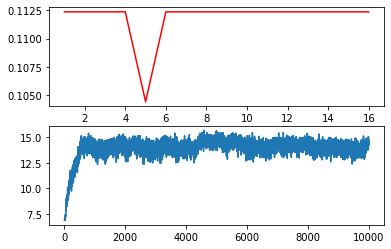

In [21]:
train()

epoch = 600.0
train acc : test acc = 0.10441666666666667 : 0.1028
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135


 [6.908888701749877, 6.900800537359459, 6.904404175497043, 6.905241955316211, 6.906603811725817, 6.9

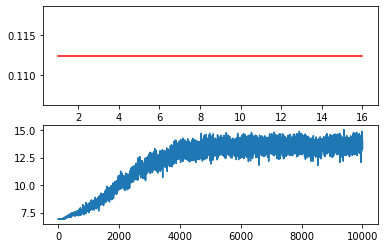

In [22]:
train(batch_size=100, learning_rate=0.01)

epoch = 600.0
train acc : test acc = 0.0993 : 0.1032
train acc : test acc = 0.0993 : 0.1032
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135


 [6.911369070985648, 6.911051142345015, 6.908769408423179, 6.903987689300958, 6.91022611330372, 6.904969329717075, 6.908649079

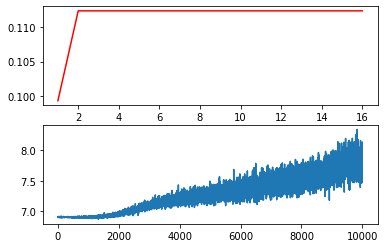

In [23]:
train(batch_size=100, learning_rate=0.001)

epoch = 120.0
train acc : test acc = 0.09863333333333334 : 0.0958
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.113

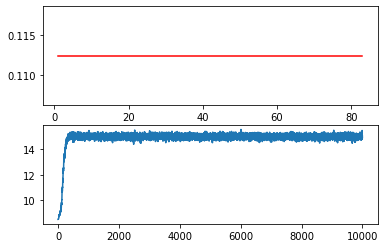

In [24]:
train(batch_size=500, learning_rate=0.1)

epoch = 60.0
train acc : test acc = 0.11776666666666667 : 0.1197
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135
train acc : test acc = 0.11236666666666667 : 0.1135

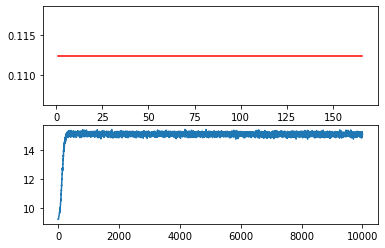

In [25]:
train(batch_size=1000, learning_rate=0.1)